# Linear Regression: Overfitting and Regularization


In this assignment, we will see how linear models overfit using examples, analyze why this happens, and determine how to diagnose and control overfitting.

In all cells with comments containing instructions, you need to write code that performs these instructions. The remaining code cells (without comments) should be executed as-is. Additionally, the assignment requires answering questions; answers should be entered after the highlighted word "__Answer:__"

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

We will work with the dataset __"bikes_rent.csv,"__ which contains daily calendar information and weather conditions characterizing automated bicycle rental stations, as well as the number of rentals on each day. We will predict the latter; thus, we will be solving a regression problem.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving bikes_rent.csv to bikes_rent.csv


In [3]:
!pip install mplcyberpunk
import mplcyberpunk

plt.style.use("cyberpunk")

### Introduction to the Data

## Task 1


Load the dataset using the __pandas.read_csv__ function into the variable __df__. Display the first 5 rows to ensure the correct data reading:

In [4]:
df = pd.read_csv("bikes_rent.csv")
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


For each rental day, the following features are known:

* _season_: 1 - spring, 2 - summer, 3 - fall, 4 - winter
* _yr_yr: 0 - 2011, 1 - 2012
* _mnth_: from 1 to 12
* _holiday_: 0 - no holiday, 1 - holiday
* _weekday_: from 0 to 6
* _workingday_: 0 - non-working day, 1 - working day
* _weathersit_: weather rating from 1 (clear, sunny day) to 4 (heavy rain, fog)
* _temp_: temperature in Celsius
* _atemp_: "feels like" temperature in Celsius
* _hum_: humidity
* _windspeed(mph)_: wind speed in miles per hour
* _windspeed(ms)_: wind speed in meters per second
* _cnt_: number of rented bicycles (this is the target variable we will predict)

So, we have continuous, binary, and nominal (ordinal) features, and all of them can be treated as continuous. We can also treat nominal features as continuous because they have an order. Let's visualize how the target variable depends on the other features.

Create plots showing the dependencies of attributes on the number of rentals. In other words, you need to create 12 plots, each illustrating the relationship between a specific attribute and the variable **cnt**.

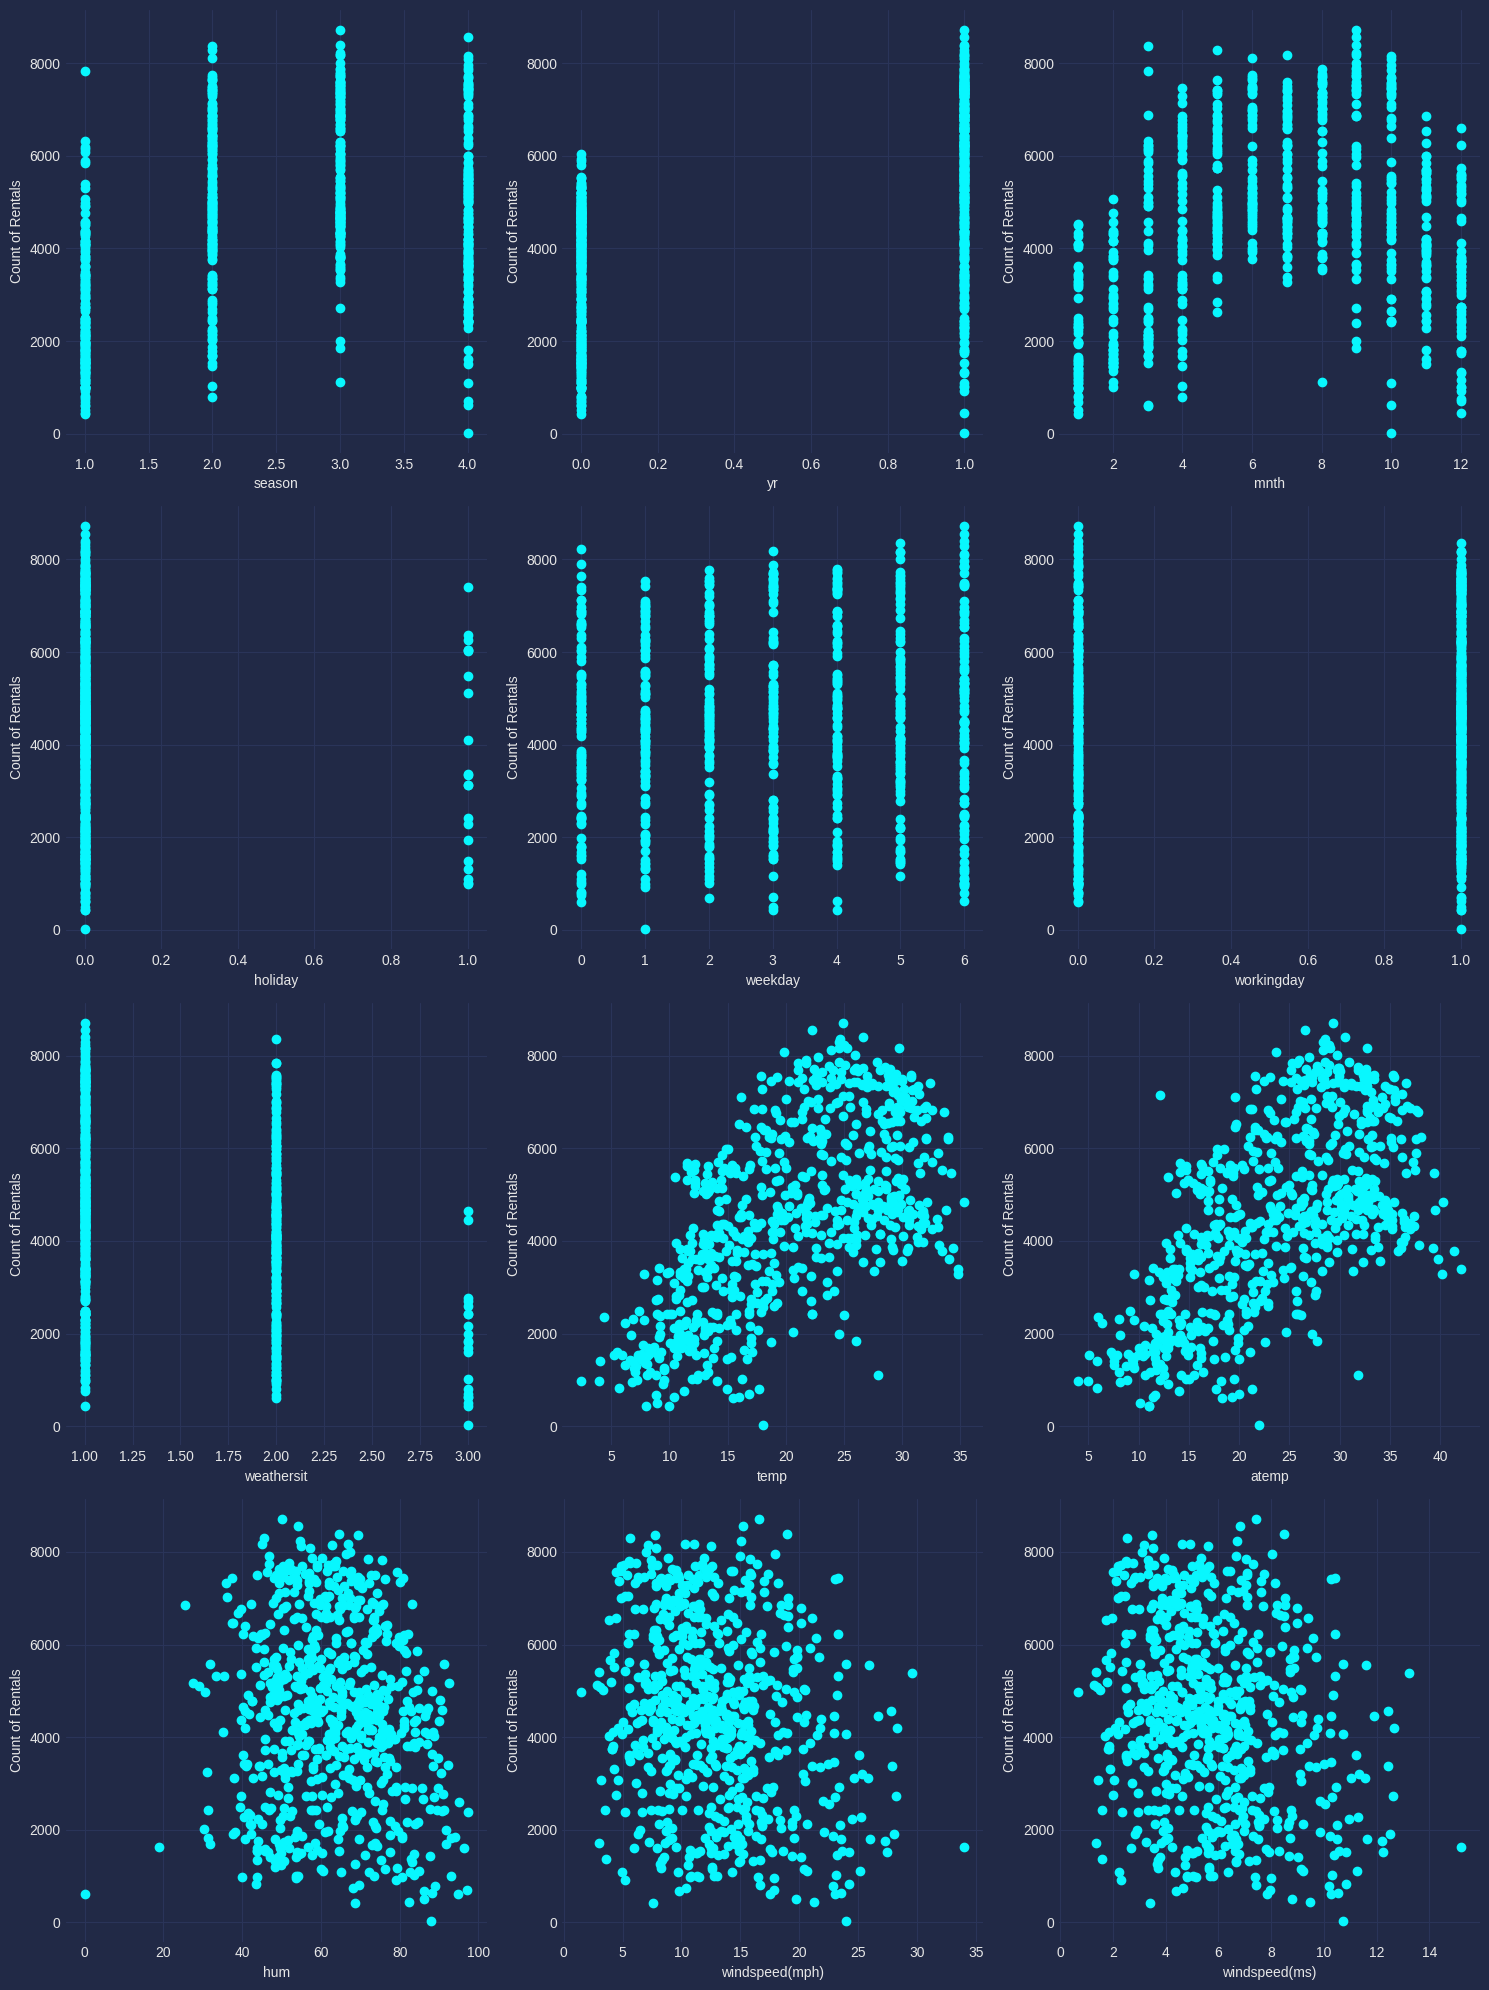

In [5]:
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
              'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

for i, attr in enumerate(attributes):
    row = i // 3
    col = i % 3

    axes[row, col].scatter(df[attr], df['cnt'])
    axes[row, col].set_xlabel(attr)
    axes[row, col].set_ylabel('Count of Rentals')

plt.tight_layout()
plt.show()

__Questions:__
1. What is the nature of the dependency of the number of rentals on the month?
1. Specify one or two factors that the number of rentals likely linearly depends on.


__Answer:__
1. Quadratic dependency.
2. Workingday, weathersit.

## Task 2

Let's more rigorously assess the level of linear dependency between the features and the target variable. A good measure of linear dependence between two vectors is the Pearson correlation. We have dealt with it before. To calculate it using pandas, you can use DataFrame methods: corr and corrwith.

Calculate the correlations of all features except the last one with the last feature using the `corrwith` method..

In [6]:
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
correlations

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


In the dataset, there are features that correlate with the target variable, which means the task can be addressed using linear methods.

From the graphs, it's evident that some features resemble each other. Therefore, let's also calculate the correlations between the continuous features.

## Task 3

Calculate pairwise correlations between the features temp, atemp, hum, windspeed(mph), windspeed(ms), and cnt using the corr method:

In [7]:
correlations = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
correlations

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


As expected, there are ones on the diagonals. However, in the matrix, there are two pairs of highly correlated columns: temp and atemp (correlated by their nature) and two windspeed columns (due to being different unit conversions). Later, we will see that this fact has a negative impact on training a linear model.

Finally, let's take a look at the mean features (using the mean method) to assess the scale of the features and the proportions of 1s in binary features.

## Task 4

Output the mean features

In [8]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


The features have different scales, so for further work, it's better to normalize the feature matrix.

### The first problem: collinear features

In our data, one feature duplicates another, and there are two more that are very similar. Of course, we could immediately remove the duplicates, but let's see how model training would proceed if we didn't notice this issue.

To begin, let's perform feature scaling or standardization: subtract the mean and divide by the standard deviation of each feature. This can be done using the scale method.

Additionally, shuffling the dataset is necessary; this will be required for cross-validation.

In [9]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [10]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Let's train a linear regression model on our data and examine the feature weights.

In [11]:
from sklearn.linear_model import LinearRegression

features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
            'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
target = 'cnt'

X = df[features]
y = df[target]

model = LinearRegression()
model.fit(X, y)

feature_weights = pd.DataFrame({'Feature': features, 'Weight': model.coef_})
feature_weights

,Feature,Weight
0,season,5.142757e+02
1,yr,2.043933e+03
2,mnth,-4.096318e+01
3,holiday,-5.193860e+02
4,weekday,6.849570e+01
5,workingday,1.212928e+02
6,weathersit,-6.064543e+02
7,temp,4.899417e+01
8,atemp,7.191633e+01
9,hum,-1.023064e+01


## Task 5

Create a linear regressor object, train it on all the data, and output the model's weights (weights are stored in the  `coef_` variable of the regressor class). You can display pairs (feature name, weight) using the `zip` function built into the Python language. Feature names are stored in the `df.columns`.


In [12]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()

X = df[df.columns[:-1]]
y = df["cnt"]
model.fit(X, y)

feature_names = df.columns[:-1]

for feature, weight in zip(feature_names, model.coef_):
    print(f"Feature: {feature}, Weight: {weight}")

Feature: season, Weight: 514.2756689772416
Feature: yr, Weight: 2043.9333206099773
Feature: mnth, Weight: -40.96317631503962
Feature: holiday, Weight: -519.3860417173415
Feature: weekday, Weight: 68.49569506058863
Feature: workingday, Weight: 121.29281595858514
Feature: weathersit, Weight: -606.4542679476724
Feature: temp, Weight: 48.994172947818015
Feature: atemp, Weight: 71.9163310082323
Feature: hum, Weight: -10.230641893838651
Feature: windspeed(mph), Weight: 2400995993962.544
Feature: windspeed(ms), Weight: -5371028038579.01


We can see that the weights for linearly dependent features are significantly larger in magnitude compared to other features. To understand why this happens, let's recall the analytical formula used to calculate the weights of a linear model in the least squares method:

$$w = (X^TX)^{-1} X^T y$$

If there are collinear (linearly dependent) columns in $X$, the matrix $X^TX$ becomes singular, and the formula ceases to be valid. The more dependent the features are, the smaller the determinant of this matrix becomes, and the worse the approximation $Xw \approx y$. This situation is known as _the problem of multicollinearity_.

Although this situation didn't occur with the slightly less correlated variable pair (temp, atemp), it's always a good practice to pay attention to the coefficients of similar features.

To solve the multicollinearity problem, regularization techniques are used. A regularizer term is added to the optimization objective, which includes the $L_1$ or $L_2$ norm of the weights multiplied by a regularization coefficient $\alpha$. In the first case, the method is called Lasso, and in the second case, it's called --- Ridge.

### Task 6
Let's try to train linear models with $L_1$ and $L_2$-regularization and then compare their weights. Train Ridge and Lasso regressors with default parameters and make sure that the issue with the weights has been resolved.

Train a linear model with $L_1$ regularization (Lasso class) and output the weights.

In [13]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_model.fit(X, y)

print("Lasso Regression:")
for feature, weight in zip(feature_names, lasso_model.coef_):
    print(f"Feature: {feature}, Weight: {weight}")


Lasso Regression:
Feature: season, Weight: 506.5512786498074
Feature: yr, Weight: 2036.2316676979037
Feature: mnth, Weight: -38.07827028932167
Feature: holiday, Weight: -484.65194618654056
Feature: weekday, Weight: 68.93837479133958
Feature: workingday, Weight: 118.4475975866837
Feature: weathersit, Weight: -604.5667118927049
Feature: temp, Weight: 51.363260585616366
Feature: atemp, Weight: 69.91273749012187
Feature: hum, Weight: -10.352705204636573
Feature: windspeed(mph), Weight: -38.34106761310847
Feature: windspeed(ms), Weight: -0.0


Train a linear model with $L_2$ regularization (Ridge class) and output the weights.

In [14]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()
ridge_model.fit(X, y)

print("Ridge Regression:")
for feature, weight in zip(feature_names, ridge_model.coef_):
    print(f"Feature: {feature}, Weight: {weight}")

Ridge Regression:
Feature: season, Weight: 507.8018818505763
Feature: yr, Weight: 2029.0890541970502
Feature: mnth, Weight: -38.470897279124635
Feature: holiday, Weight: -493.2780154838191
Feature: weekday, Weight: 69.11396965165964
Feature: workingday, Weight: 121.5244250292943
Feature: weathersit, Weight: -605.205555373153
Feature: temp, Weight: 49.31676759598743
Feature: atemp, Weight: 71.7859872733456
Feature: hum, Weight: -10.383394500484615
Feature: windspeed(mph), Weight: -31.93550169428455
Feature: windspeed(ms), Weight: -14.276040263842843


### Task 7

Unlike $L_2$ regularization, $L_1$ regularization can zero out weights for certain features. Let's observe how the weights change as the regularization coefficient $\alpha$ increases.

For each value of the coefficient from `alphas`, train a `Lasso` regressor and record the weights in the `coefs_lasso` list. Then, train a `Ridge` regressor and record the weights in the `coefs_ridge` list. Convert the obtained lists into `np.array`.

In [15]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:

    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    coefs_lasso.append(lasso_model.coef_)

    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    coefs_ridge.append(ridge_model.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Analyze the dynamics of the weights as the regularization parameter increases:

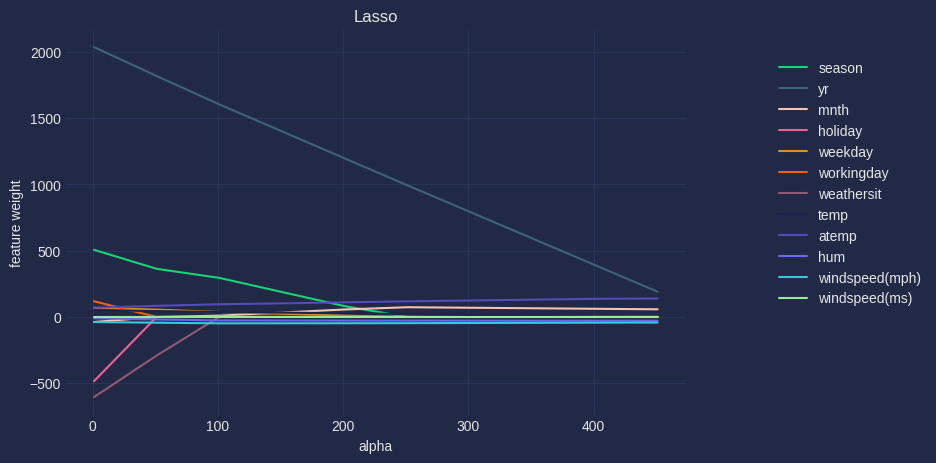

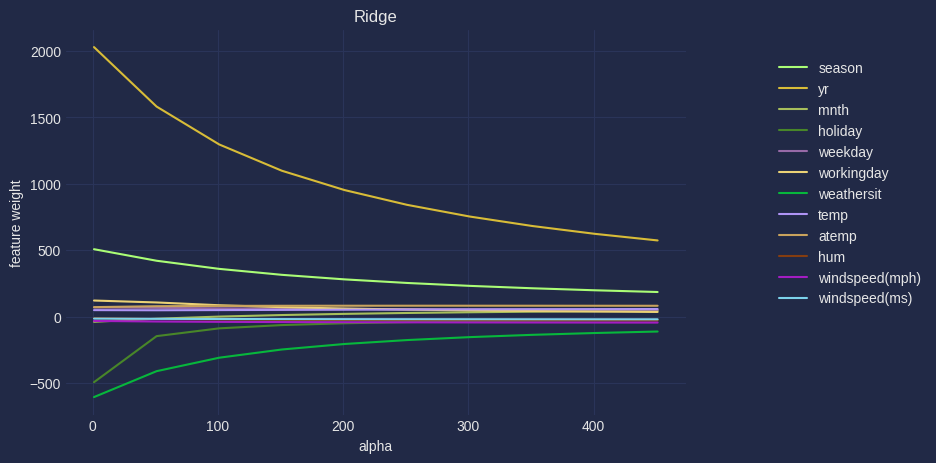

In [16]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Let's analyze the graphs and answer the following questions:

1. Which regularizer (Ridge or Lasso) aggressively reduces weights for the same alpha value?
2. What will happen to the Lasso weights if alpha is set to a very large value? Explain why this happens.
3. Can we claim that Lasso excludes one of the windspeed features for any alpha > 0? What about Ridge? It is considered that a regularizer excludes a feature if its coefficient becomes smaller than $10^{-3}$.
4. Which of the regularizers is more suitable for feature selection of uninformative features?

__Answer:__

1. Lasso is more aggressive in reducing weights for the same alpha value. In Lasso, the $L1$ regularization term encourages sparsity, leading to some weights being exactly zero.

2. If alpha is set to a very large value in Lasso, most of the feature weights will be driven to exactly zero. This is because the $L1$ penalty term becomes dominant, and the optimization tends to reduce coefficients to zero to minimize the objective function. This encourages feature selection, effectively excluding less important features from the model.

3. Yes, we can claim that Lasso will exclude one of the _windspeed_ features for any alpha > 0. This is evident from the Lasso weights converging to zero for high alpha values. Ridge, on the other hand, doesn't exactly exclude features; it only shrinks their weights. It might not make the coefficient smaller than $10^{-3}$ for larger alpha values.

4. Lasso

### Task 8

Next, we will continue working with `Lasso`.

So far, we've observed that the model adjusts feature coefficients differently when changing the alpha value. We need to choose the best alpha.

To do this, first, we need an evaluation metric. We will use the same optimization objective of the least squares method as our metric, which is the `Mean Square Error` (MSE).

Secondly, we need to decide on the data to compute this metric. We cannot choose `alpha` based on the MSE value on the training dataset alone because it won't reflect how well the model will perform on new, unseen data. If we use a single train-test split (this is called holdout), we might overfit to specific "new" data and lose generalization. Therefore, we will perform multiple splits of the dataset, try different alpha values on each split, and then average the MSE scores. The most convenient way to do this is through cross-validation. We will divide the dataset into $K$ parts and, for each iteration, use one part as the test set while using the remaining parts to create the training set. This process helps us estimate the model's performance on unseen data.

Performing cross-validation for regression in sklearn is quite straightforward. There is a specialized regressor called __LassoCV__, that takes a list of alpha values as input and calculates the MSE using cross-validation for each alpha. After fitting (if you leave the cv parameter as the default value of 3), the regressor will have the variable __mse\_path\___, a matrix of size len(alpha) x k, where k = 3 (the number of cross-validation folds), containing the MSE values on the test set for the corresponding runs. Additionally, the chosen value of the regularization parameter will be stored in the variable alpha\_, and the learned weights will be in coef\_.

Please note that the regressor might change the order in which it iterates over the alphas; for matching with the MSE matrix, it's better to use the alphas_ variable of the regressor.

Train the `LassoCV` regressor on all the regularization parameters from alpha. Plot the averaged row-wise `MSE` as a function of `alpha` using the `create_plot` function.

Output the chosen `alpha`, as well as the pairs "feature-coefficient" for the trained coefficient vector.

In [17]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

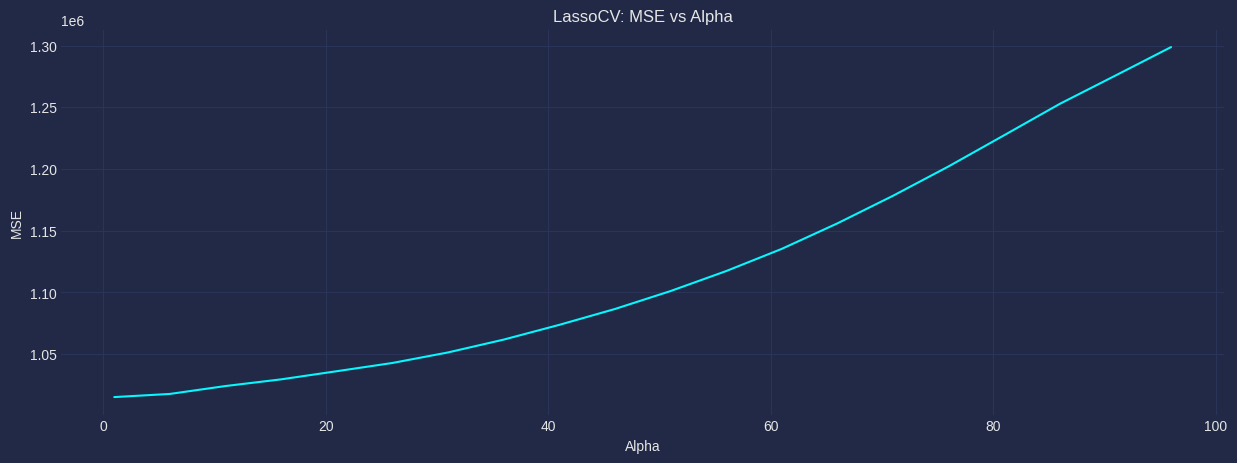

Selected Alpha: 1
Feature - Coefficient pairs:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


In [18]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=5).fit(X, y)

data = list(zip(regressor.alphas_, np.mean(regressor.mse_path_, axis=1)))

create_plot(data, "LassoCV: MSE vs Alpha", "Alpha", "MSE")

coefficients = list(zip(df.columns[:-1], regressor.coef_))
print(f"Selected Alpha: {regressor.alpha_}")
print("Feature - Coefficient pairs:")
for feature, coef in coefficients:
    print(f"{feature}: {coef}")

So, we have chosen a certain regularization parameter. Let's see what alpha values we would have chosen if we had split the dataset only once into training and testing, meaning we will examine the MSE trajectories corresponding to individual blocks of the dataset.

### Task 9

Display the values of `alpha` corresponding to the minimum `MSE` for each split (i.e., column-wise).
Visualize the columns of `mse_path_` on three separate graphs.

Alphas with minimum MSE:
Alpha = 51, MSE = 439770.52414748847
Alpha = 1, MSE = 1130514.6005888924
Alpha = 96, MSE = 515174.2548115462
Alpha = 1, MSE = 1287109.4294665914
Alpha = 1, MSE = 1370779.8724015509


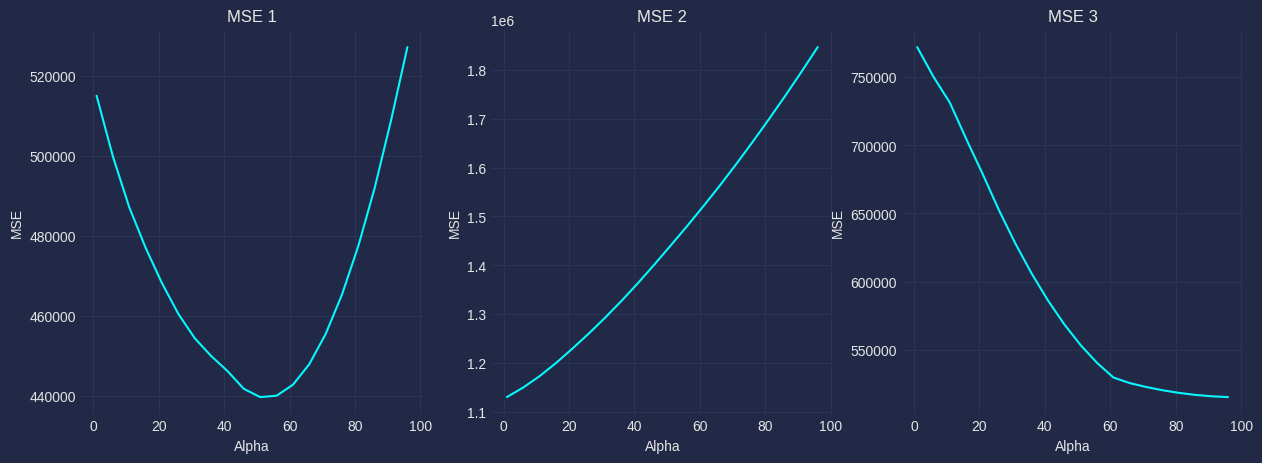

In [19]:
min_mse_indices = np.argmin(regressor.mse_path_, axis=0)

print("Alphas with minimum MSE:")
for i, idx in enumerate(min_mse_indices):
    alpha = regressor.alphas_[idx]
    mse = regressor.mse_path_[idx, i]
    print(f"Alpha = {alpha}, MSE = {mse}")


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    ax.plot(regressor.alphas_, regressor.mse_path_[:, i])
    ax.set_title(f"MSE {i+1}")
    ax.set_xlabel("Alpha")
    ax.set_ylabel("MSE")

plt.show()

In each split, there is a unique optimal value of `alpha`, and it corresponds to larger MSE values on other splits. This implies that we are tuning the model to specific training and validation sets. When choosing `alpha` through cross-validation, we aim to find a "middle ground" that yields acceptable metric values across different splits of the dataset.

### Task 10

Finally, as is customary in data analysis, let's interpret the result. Answer the following questions.

#### Question 1

In the last trained model, select the 4 features with the largest (positive) coefficients (list them), and examine the visualizations of the dependencies between `cnt` and these features that we created in the "Getting Acquainted with the Data" section. Can you see an increasing linear relationship between `cnt` and these features from the graphs? Does it make sense to claim (based on common sense) that the higher the values of these features, the more people would want to rent bicycles?

__Answer:__

Yes

Top features: ['atemp', 'workingday', 'season', 'yr']


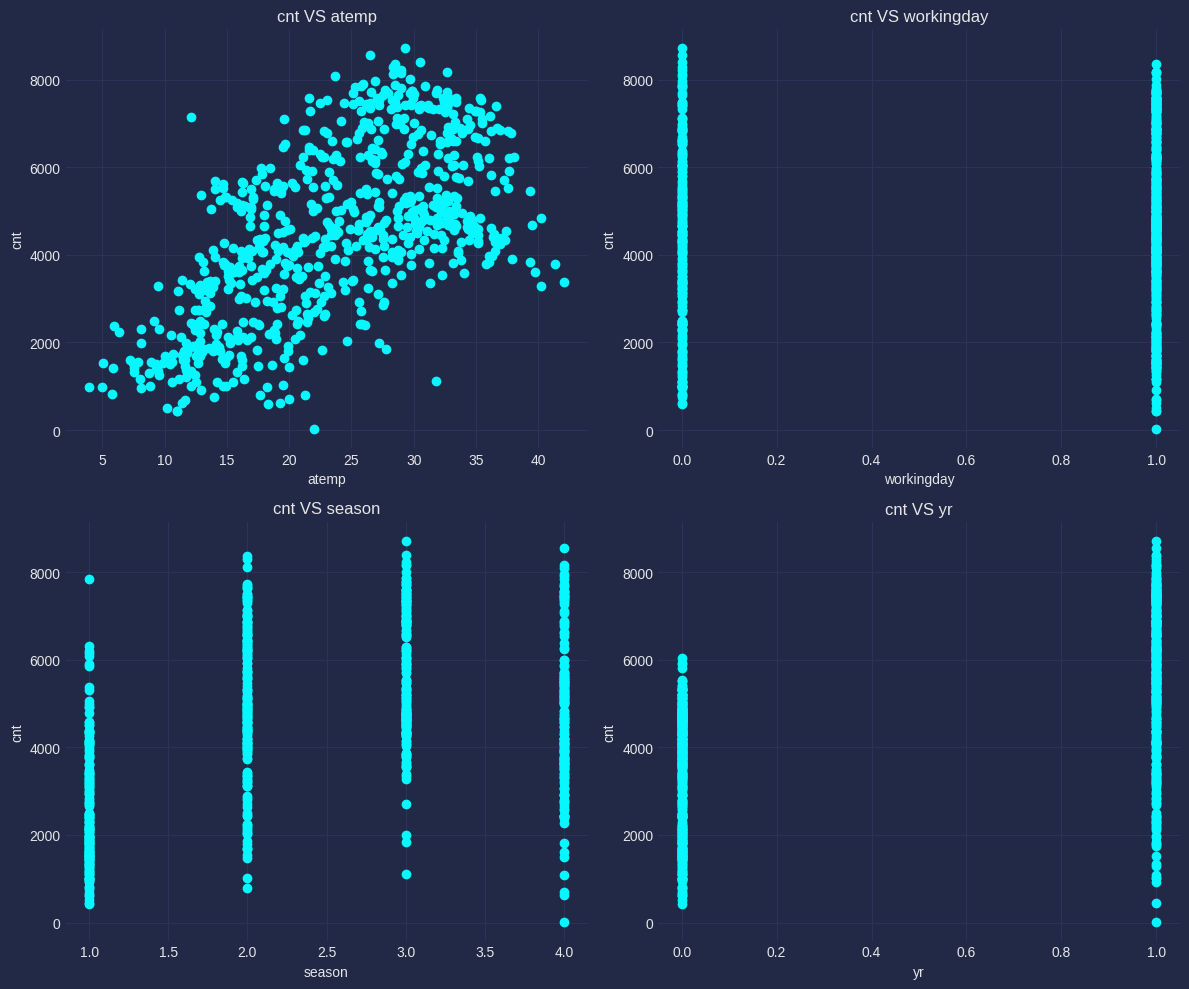

In [20]:
coefficients = regressor.coef_
top_features_indices = np.argsort(coefficients)[-4:]
top_features = df.columns[top_features_indices]
features = []

for feature in top_features:
    features.append(feature)

print(f"Top features: {features}")

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    axs[row, col].scatter(df[feature], df['cnt'])
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('cnt')
    axs[row, col].set_title(f'cnt VS {feature}')

plt.tight_layout()
plt.show()


__Conclusion__:

The most influential factor on the number of rented bicycles is temperature.

#### Question 2

Select the 3 features with the largest absolute negative coefficients (list them), and examine the corresponding visualizations. Can you observe a decreasing linear relationship? Does it make sense to claim that the higher the values of these features, the fewer people would want to rent bicycles?

__Answer:__

Yes

Top 3 features with highest negative coefficients: ['weathersit', 'holiday', 'windspeed(mph)']


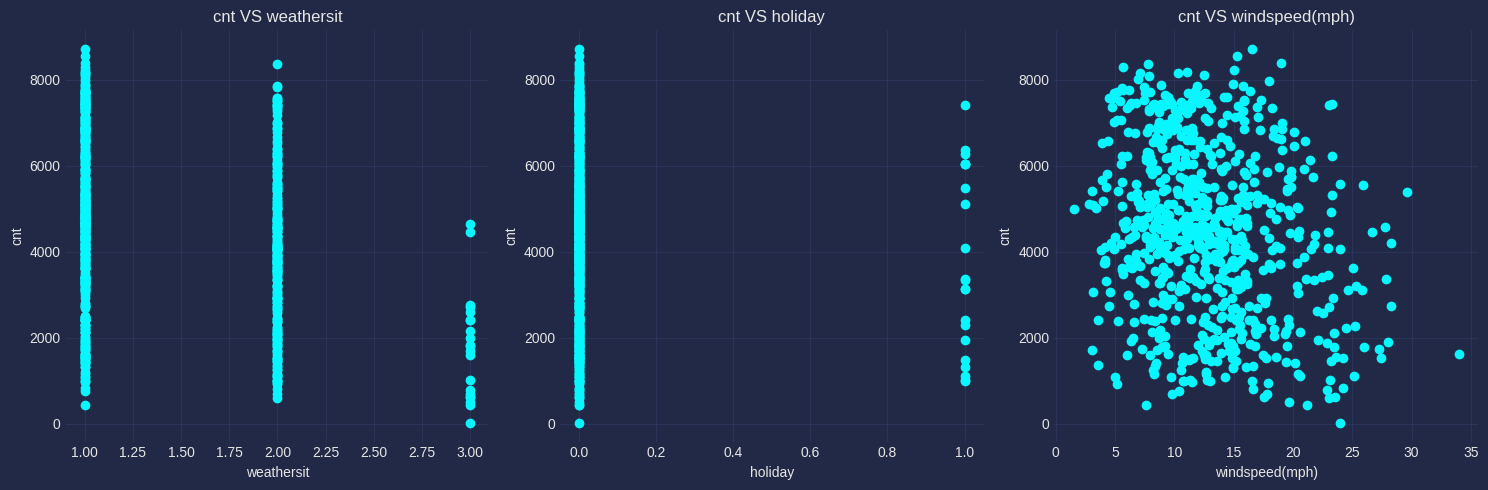

In [21]:
top_negative_indices = np.argsort(coefficients)[:3]
feature_names = df.columns[:-1]
top_negative_features = feature_names[top_negative_indices]

print(f"Top 3 features with highest negative coefficients: {feature_names[top_negative_indices].tolist()}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(top_negative_features):
    axs[i].scatter(df[feature], df['cnt'])
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('cnt')
    axs[i].set_title(f'cnt VS {feature}')

plt.tight_layout()
plt.show()

__Conclusion:__

Increasing the value of the feature leads to a decrease in the number of rented bicycles.

#### Question 3

List the features with coefficients close to zero (< 1e-3). Why do you think the model excluded them (take another look at the graphs)? Is it true that they have no impact on bicycle demand?

__Answer:__

Not

In [22]:
features_near_zero = {feat: coef for feat, coef in zip(df.columns, regressor.coef_) if abs(coef) < 1e-3}
print("Features with coefficients near zero:", ', '.join([f"'{feat}': {coef}" for feat, coef in features_near_zero.items()]))

Features with coefficients near zero: 'windspeed(ms)': -0.0


__Conclusion:__

The "windspeed" feature does influence the demand, but its coefficient is close to zero because it duplicates another feature.

### Conclusion

So, we have examined how to monitor the adequacy of a linear model, how to select features, and how to intelligently, if possible without biasing towards specific data portions, tune the regularization coefficient.

It is worth noting that cross-validation is convenient for tuning only a small number of parameters (1, 2, maximum 3), as for each permissible combination, the model needs to be trained multiple times. This process can be time-consuming, especially when dealing with large datasets.